In [10]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from custom_transforms import RandomTextPut, RandomCirclePut
from datasets import MyDataset
from  torchvision import transforms
from torch.optim import lr_scheduler
from torchvision import models
from tqdm import tqdm
from torch import nn, optim
import pickle
from torch.utils.data import DataLoader, ConcatDataset
from vision_learner import VisionModel
import torch
import numpy as np
import random

In [11]:
SEED = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [12]:
df = pd.read_csv('images.csv')
df.head()

,name,isTemplate,exampleId,exampleText,filename,url,path
0,drake hotline bling,True,NaN,NaN,drake hotline bling.jpg,https://imgflip.com/s/meme/Drake-Hotline-Bling...,C:\Users\yromm\OneDrive\Рабочий стол\memedet\r...
1,drake hotline bling,False,0.0,Drake Hotline Bling | WEBSITES BE LIKE:; pay ...,drake hotline bling_0.jpg,https://i.imgflip.com/6sh1va.jpg,C:\Users\yromm\OneDrive\Рабочий стол\memedet\r...
2,drake hotline bling,False,1.0,People have a hard time defining what the 2000...,drake hotline bling_1.jpg,https://i.imgflip.com/6sero4.jpg,C:\Users\yromm\OneDrive\Рабочий стол\memedet\r...
3,drake hotline bling,False,2.0,Is the same but not | 5 second ad you can't s...,drake hotline bling_2.jpg,https://i.imgflip.com/6smp9c.jpg,C:\Users\yromm\OneDrive\Рабочий стол\memedet\r...
4,drake hotline bling,False,3.0,"Drake Hotline Bling | Catching a Pokemon, giv...",drake hotline bling_3.jpg,https://i.imgflip.com/6s5ttu.jpg,C:\Users\yromm\OneDrive\Рабочий стол\memedet\r...


In [20]:
train_df = df.query('isTemplate')
test_df = df.query('~isTemplate')

In [21]:
train_transforms = transforms.Compose(
    [
        #transforms.Resize((300, 300)),
        RandomTextPut(),
        RandomCirclePut(),
        transforms.RandomRotation((-25, 25)),
        transforms.RandomPerspective(0.2, 0.5),
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [22]:
train_dataset = ConcatDataset(
    [MyDataset(train_df, "train", train_transforms, "path", "name") for _ in range(15)]
)
val_dataset = MyDataset(test_df, "val", test_transforms, "path", "name", train_dataset.datasets[0].label_encoder)


In [23]:
train = DataLoader(train_dataset, batch_size=128, shuffle=True)
val = DataLoader(val_dataset, batch_size=128, shuffle=True)
dataloaders = {"train": train, "val": val}

In [24]:
import matplotlib.pyplot as plt
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

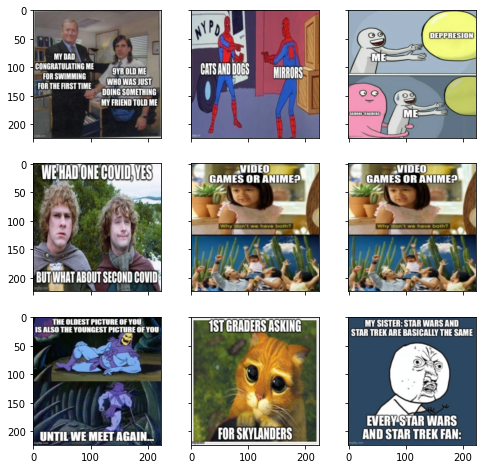

In [25]:

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 950))
    im_val, label = val_dataset[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

In [27]:
rn18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to('cuda')
rn18.fc = nn.Linear(
    in_features=rn18.fc.in_features, out_features=train_df.name.nunique(), bias=True
).to('cuda')

In [28]:
model = VisionModel(rn18, dataloaders)

In [29]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(rn18.parameters(), lr=2e-4, weight_decay=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [30]:
model.fit(10, loss, optimizer, scheduler)

Epoch 000


Phase train: 100%|██████████| 114/114 [07:51<00:00,  4.14s/it]


	Loss: 4.85902, Accuracy 0.43817
----------------------------------------
Epoch 001


Phase train: 100%|██████████| 114/114 [07:30<00:00,  3.95s/it]


	Loss: 1.36333, Accuracy 0.93037


Phase val: 100%|██████████| 102/102 [01:55<00:00,  1.13s/it]


	Loss: 0.82644, Accuracy 0.93381
----------------------------------------
Epoch 002


Phase train: 100%|██████████| 114/114 [07:46<00:00,  4.09s/it]


	Loss: 0.33158, Accuracy 0.97053


Phase val: 100%|██████████| 102/102 [02:12<00:00,  1.30s/it]


	Loss: 0.46259, Accuracy 0.95642
----------------------------------------
Epoch 003


Phase train: 100%|██████████| 114/114 [08:04<00:00,  4.25s/it]


	Loss: 0.17509, Accuracy 0.98520


Phase val: 100%|██████████| 102/102 [02:04<00:00,  1.22s/it]


	Loss: 0.37923, Accuracy 0.96731
----------------------------------------
Epoch 004


Phase train: 100%|██████████| 114/114 [06:20<00:00,  3.34s/it]


	Loss: 0.15066, Accuracy 0.98979


Phase val: 100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


	Loss: 0.35285, Accuracy 0.96831
----------------------------------------
Epoch 005


Phase train: 100%|██████████| 114/114 [06:22<00:00,  3.35s/it]


	Loss: 0.13696, Accuracy 0.99184


Phase val: 100%|██████████| 102/102 [01:38<00:00,  1.03it/s]


	Loss: 0.34133, Accuracy 0.97119
----------------------------------------
Epoch 006


Phase train: 100%|██████████| 114/114 [06:18<00:00,  3.32s/it]


	Loss: 0.13034, Accuracy 0.99397


Phase val: 100%|██████████| 102/102 [01:41<00:00,  1.01it/s]


	Loss: 0.35052, Accuracy 0.96924
----------------------------------------
Epoch 007


Phase train: 100%|██████████| 114/114 [06:36<00:00,  3.48s/it]


	Loss: 0.12897, Accuracy 0.99290


Phase val: 100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


	Loss: 0.34385, Accuracy 0.97076
----------------------------------------
Epoch 008


Phase train: 100%|██████████| 114/114 [06:25<00:00,  3.38s/it]


	Loss: 0.12777, Accuracy 0.99356


Phase val: 100%|██████████| 102/102 [01:45<00:00,  1.04s/it]


	Loss: 0.34723, Accuracy 0.97157
----------------------------------------
Epoch 009


Phase train: 100%|██████████| 114/114 [06:21<00:00,  3.35s/it]


	Loss: 0.12797, Accuracy 0.99376


Phase val: 100%|██████████| 102/102 [01:53<00:00,  1.12s/it]

	Loss: 0.33878, Accuracy 0.97289
----------------------------------------
Best val Acc: 0.972886


{'train': [4.859015199176052,
  1.363326609134674,
  0.3315817062792025,
  0.17509074117008008,
  0.1506562617264296,
  0.13695756117241425,
  0.13033619313909298,
  0.1289749244848887,
  0.1277692598993318,
  0.12797201313731962],
 'val': [0.8264429931547127,
  0.4625907727316314,
  0.37922681707377526,
  0.3528529620345901,
  0.3413342883189519,
  0.3505169189735955,
  0.34384915714754777,
  0.3472323712765002,
  0.33878116338860753]}

In [35]:
model.eval()
model.predict(Image.open(df.path[123]))

array(['two buttons'], dtype=object)

In [36]:
torch.save(model.best_weights, 'models/rn18_weights.pt')

In [38]:
pickle.dump(model, open('models/rn18_model.pkl', 'wb'))

In [45]:
pickle.dump(model.state_dict(), open('models/rn18_model_state_dict.pkl', 'wb'))